In [1]:
#!pip install pyodbc
#!pip install lightgbm


In [2]:
import pandas as pd
import numpy as np
import math as m
import pyodbc
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier


# Extract CSV files

In [3]:
df_Expenditures = pd.read_csv("Expenditures.csv")
df_Expenditures.head()

,EXPENDITURE_ID,HOUSEHOLD_ID,YEAR,MONTH,PRODUCT_CODE,COST,GIFT,IS_TRAINING
0,1,3111041,2015,1,10210,3.89,0,1
1,10,3111041,2015,1,120310,4.66,0,1
2,100,3111051,2015,2,190211,9.79,0,1
3,1000,3111402,2015,2,40510,2.95,0,1
4,10000,3114161,2015,1,190321,2.12,0,1


In [4]:
df_HOUSEHOLDS = pd.read_csv("HOUSEHOLDS.csv")
df_HOUSEHOLDS.head()

,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF
0,3111041,2015,0.304403,0.144808,0.142726,0.143244,0.142180,0.138187,0.126976,66
1,3111042,2015,0.306346,0.146156,0.144356,0.144592,0.143528,0.139535,0.128324,66
2,3111051,2015,0.693114,0.622172,0.620369,0.622960,0.613054,0.612297,0.620679,48
3,3111052,2015,0.692559,0.621617,0.619814,0.622405,0.612499,0.611743,0.620124,48
4,3111061,2015,0.281706,0.112993,0.112831,0.109800,0.111553,0.109168,0.095098,37


In [5]:
df_HOUSEHOLD_MEMBERS = pd.read_csv("HOUSEHOLD_MEMBERS.csv")
df_HOUSEHOLD_MEMBERS.head()

,HOUSEHOLD_ID,YEAR,MARITAL,SEX,AGE,WORK_STATUS
0,3111041,2015,1,1,66,\0
1,3111042,2015,1,1,66,\0
2,3111091,2015,1,1,56,\0
3,3111092,2015,1,1,56,\0
4,3111111,2015,1,1,50,1


We want to get the maximum size of each non numeric column. This will help us design the maximum varchar length for each column when we build our table in SQL Server.

In [6]:
def Get_maximum_character_length_for_non_numeric_columns(df):
  columns = df.select_dtypes(exclude='number').columns.tolist()
  #print(columns)
  dict_columns = {c : df_HOUSEHOLD_MEMBERS.loc[:,c].str.len().max() for c in columns}
  return df.info(), dict_columns

In [7]:
dataframes = [df_Expenditures, df_HOUSEHOLDS, df_HOUSEHOLD_MEMBERS]
for df in dataframes:
  print(Get_maximum_character_length_for_non_numeric_columns(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020634 entries, 0 to 2020633
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EXPENDITURE_ID  int64  
 1   HOUSEHOLD_ID    int64  
 2   YEAR            int64  
 3   MONTH           int64  
 4   PRODUCT_CODE    int64  
 5   COST            float64
 6   GIFT            int64  
 7   IS_TRAINING     int64  
dtypes: float64(1), int64(7)
memory usage: 123.3 MB
(None, {})
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56812 entries, 0 to 56811
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HOUSEHOLD_ID      56812 non-null  int64  
 1   YEAR              56812 non-null  int64  
 2   INCOME_RANK       56812 non-null  float64
 3   INCOME_RANK_1     56812 non-null  float64
 4   INCOME_RANK_2     56812 non-null  float64
 5   INCOME_RANK_3     56812 non-null  float64
 6   INCOME_RANK_4     56812 non-null  float64
 7 

In [8]:
df_Expenditures.isnull().sum()

EXPENDITURE_ID    0
HOUSEHOLD_ID      0
YEAR              0
MONTH             0
PRODUCT_CODE      0
COST              0
GIFT              0
IS_TRAINING       0
dtype: int64

Only work status is non_numeric

The code below was derived from Microsoft's documentation (Insert Python dataframe into SQL table).
link: https://learn.microsoft.com/en-us/sql/machine-learning/data-exploration/python-dataframe-sql-server?view=sql-server-ver17


The details below allow us access to the correct SQL server for the imiplemention of this project.

In [9]:
server = 'DESKTOP-M8H3JN9\SQLEXPRESS'
database = 'US_EXPENDITURES'
username = 'username'
password = 'password'
MARS_Connection = 'Yes' # This allows for multiple queries to be run.
TrustServerCertificate = 'yes'

Connection to database

In [10]:
# Measure start of SQL processes.
SQL_start_time = time.time()

This is our connection string. Its how we are granted access to the SQL Server and Database

In [11]:
conx = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password+ ';TrustServerCertificate='+ TrustServerCertificate+ ';MARS_Connection='+ MARS_Connection)

# Load dataframes into SQL Tables

In [12]:
cursor = conx.cursor()

## Drop and re-create SQL Tables

This process triggers a stored procedure ([US_EXPENDITURES].[dbo].[US_Expenditure_Table_Creation_ETL]) that drops and re-creates tables US_EXPENDITURES.DBO.HOUSEHOLD_MEMBERS,
US_EXPENDITURES.DBO.HOUSEHOLDS, US_EXPENDITURES.DBO.EXPENDITURES and the final derived table (US_EXPENDITURES.DBO.HOUSEHOLDS_DERIVED_FEATURES).
This allows our process to be reproducable.

This process should occur before we insert of dataframe into SQL

In [13]:
cursor.execute("EXEC   [US_EXPENDITURES].[dbo].[US_Expenditure_Table_Creation_ETL]")

### Confirm each SQL table is empty by loading data into them
We want to confirm the tables are empty before we begin loading data into them

In [14]:
Confirm_household_members_table_is_empty = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.HOUSEHOLD_MEMBERS"
Confirm_households_table_is_empty = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.HOUSEHOLDS"
Confirm_expenditure_table_is_empty = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.EXPENDITURES"
df_Confirm_household_members_table_is_empty = pd.read_sql(Confirm_household_members_table_is_empty, conx)
df_Confirm_households_table_is_empty = pd.read_sql(Confirm_households_table_is_empty, conx)
df_Confirm_expenditure_table_is_empty  = pd.read_sql(Confirm_expenditure_table_is_empty, conx)

C:\Users\me\AppData\Local\Temp\ipykernel_19272\4006561089.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_household_members_table_is_empty = pd.read_sql(Confirm_household_members_table_is_empty, conx)
C:\Users\me\AppData\Local\Temp\ipykernel_19272\4006561089.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_households_table_is_empty = pd.read_sql(Confirm_households_table_is_empty, conx)
C:\Users\me\AppData\Local\Temp\ipykernel_19272\4006561089.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  d

### Load dataframes df_HOUSEHOLD_MEMBERS,df_Expenditures, df_HOUSEHOLD_MEMBERS into SQL tables

In [15]:
for index, row in df_HOUSEHOLD_MEMBERS.iterrows():
     cursor.execute("INSERT INTO US_EXPENDITURES.DBO.HOUSEHOLD_MEMBERS (HOUSEHOLD_ID,YEAR,MARITAL,SEX,AGE,WORK_STATUS) values(?,?,?,?,?,?)", row.HOUSEHOLD_ID, row.YEAR,row.MARITAL,row.SEX,row.AGE,row.WORK_STATUS)
conx.commit()

In [16]:
for index, row in df_HOUSEHOLDS.iterrows():
   cursor.execute("INSERT INTO US_EXPENDITURES.DBO.HOUSEHOLDS (HOUSEHOLD_ID, YEAR, INCOME_RANK, INCOME_RANK_1, INCOME_RANK_2, INCOME_RANK_3, INCOME_RANK_4, INCOME_RANK_5, INCOME_RANK_MEAN, AGE_REF) values(?,?,?,?,?,?,?,?,?,?)", row.HOUSEHOLD_ID, row.YEAR, row.INCOME_RANK, row.INCOME_RANK_1, row.INCOME_RANK_2, row.INCOME_RANK_3, row.INCOME_RANK_4, row.INCOME_RANK_5, row.INCOME_RANK_MEAN, row.AGE_REF)
conx.commit()

In [17]:
for index, row in df_Expenditures.iterrows():
    cursor.execute("INSERT INTO US_EXPENDITURES.DBO.EXPENDITURES (EXPENDITURE_ID, HOUSEHOLD_ID, YEAR, MONTH, PRODUCT_CODE, COST, GIFT, IS_TRAINING) values(?,?,?,?,?,?,?,?)", row.EXPENDITURE_ID,row. HOUSEHOLD_ID, row.YEAR, row.MONTH, row.PRODUCT_CODE, row.COST, row.GIFT, row.IS_TRAINING)
conx.commit()

### Confirm there is data in the first row of each table

In [18]:
Confirm_household_members_table = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.HOUSEHOLD_MEMBERS"
Confirm_households_table = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.HOUSEHOLDS"
Confirm_expenditure_table = f"SELECT TOP 1 * FROM US_EXPENDITURES.DBO.EXPENDITURES"
df_Confirm_household_members_table = pd.read_sql(Confirm_household_members_table, conx)
df_Confirm_households_table = pd.read_sql(Confirm_households_table, conx)
df_Confirm_expenditure_table  = pd.read_sql(Confirm_expenditure_table, conx)

C:\Users\me\AppData\Local\Temp\ipykernel_19272\1596194484.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_household_members_table = pd.read_sql(Confirm_household_members_table, conx)
C:\Users\me\AppData\Local\Temp\ipykernel_19272\1596194484.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_households_table = pd.read_sql(Confirm_households_table, conx)
C:\Users\me\AppData\Local\Temp\ipykernel_19272\1596194484.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_expenditure_table  = pd.re

### Confirm derived final table is empty before SQL data cleaning and transformation process

In [19]:
Confirm_derived_table_is_empty = f"SELECT * FROM US_EXPENDITURES.DBO.HOUSEHOLDS_DERIVED_FEATURES"
df_Confirm_derived_table_is_empty = pd.read_sql(Confirm_derived_table_is_empty, conx)

C:\Users\me\AppData\Local\Temp\ipykernel_19272\3652596092.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Confirm_derived_table_is_empty = pd.read_sql(Confirm_derived_table_is_empty, conx)


## SQL Cleaning and Transformation process
This process triggers the stored procedure [US_EXPENDITURES].[dbo].[Derive_Household_Features]. This stored procedure implements data cleaning, 
data transformations, and populates table US_EXPENDITURES.DBO.HOUSEHOLDS_DERIVED_FEATURES with our final dataset

In [20]:
cursor.execute("EXEC  [US_EXPENDITURES].[dbo].[Derive_Household_Features]")

# Data Integration 

Put SQL table into Python dataframe
This process represents the data integration between SQL Server and Python. We take our derieved SQL Table and convert it into our final dataframe for Python EDA, optimization and model building.

In [21]:
query = f"SELECT * FROM US_EXPENDITURES.DBO.HOUSEHOLDS_DERIVED_FEATURES"
#this dataframe has the derived features
df = pd.read_sql(query, conx)

C:\Users\me\AppData\Local\Temp\ipykernel_19272\3178575190.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conx)


In [22]:
conx.close()

In [23]:
SQL_end_time = time.time()

Now we confirm that our tables were indeed empty before we started the loading process and we confirm that they are longer empty after the loading process.

In [24]:
df_Confirm_household_members_table_is_empty

,HOUSEHOLD_ID,YEAR,MARITAL,SEX,AGE,WORK_STATUS


In [25]:
df_Confirm_household_members_table

,HOUSEHOLD_ID,YEAR,MARITAL,SEX,AGE,WORK_STATUS
0,3111041,2015,1,1,66,\0


In [26]:
df_Confirm_households_table_is_empty

,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF


In [27]:
df_Confirm_households_table 

,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF
0,3111041,2015,0.304403,0.144808,0.142726,0.143244,0.14218,0.138187,0.126976,66


In [28]:
df_Confirm_expenditure_table_is_empty

,EXPENDITURE_ID,HOUSEHOLD_ID,YEAR,MONTH,PRODUCT_CODE,COST,GIFT,IS_TRAINING


In [29]:
df_Confirm_expenditure_table 

,EXPENDITURE_ID,HOUSEHOLD_ID,YEAR,MONTH,PRODUCT_CODE,COST,GIFT,IS_TRAINING
0,1,3111041,2015,1,10210,3.89,0,1


In [30]:
df_Confirm_derived_table_is_empty

,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF,...,NUMBER_OF_GIFTS,NUMBER_OF_PURCHASES,BAND_ONE_PURCHASES,BAND_TWO_PURCHASES,BAND_THREE_PURCHASES,BAND_FOUR_PURCHASES,BAND_FIVE_PURCHASES,BAND_SEX_PURCHASES,BAND_SEVEN_PURCHASES,TOTAL_SPENT


In [31]:
df.info() # This is the derived final table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52738 entries, 0 to 52737
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   HOUSEHOLD_ID                           52738 non-null  int64  
 1   YEAR                                   52738 non-null  int64  
 2   INCOME_RANK                            52738 non-null  float64
 3   INCOME_RANK_1                          52738 non-null  float64
 4   INCOME_RANK_2                          52738 non-null  float64
 5   INCOME_RANK_3                          52738 non-null  float64
 6   INCOME_RANK_4                          52738 non-null  float64
 7   INCOME_RANK_5                          52738 non-null  float64
 8   INCOME_RANK_MEAN                       52738 non-null  float64
 9   AGE_REF                                52738 non-null  int64  
 10  NUMBER_OF_HOUSEHOLD_JOBS               52738 non-null  int64  
 11  NU

In [32]:
print(f"SQL processes took {round((SQL_end_time - SQL_start_time)/60,0)} minutes to run")

SQL processes took 35.0 minutes to run


# EDA - Python Section

In [33]:
df_original = df.copy()

## Feature Removal Based on Correlation Heatmap

Based on the Correlation heatmap (below), it is clear that features : INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5 and INCOME_RANK_MEAN have the same correlation with the "pseudo" target variable (TOTAL_SPENT) and
simliar correlations with other features. Therefore, we will remove features INCOME_RANK_1 to INCOME_RANK_5 and only include the INCOME_RANK_MEAN. This will reduce dimensionailty.

Number of NUMBER_OF_HOUSEHOLD_MEMBERS_WITH_JOBS and NUMBER_OF_HOUSEHOLD_JOBS are strongly correlated (0.94 correlation) with each other and both features have a simliar correlation with the "pseudo" target variable. We therefore remove NUMBER_OF_HOUSEHOLD_MEMBERS_WITH_JOBS feature.

Although NUMBER_OF_PURCHASES and BAND_SEVEN_PURCHASES have simliar correlations with each other, their correlations with the "pseudo" target variable is different. We therefore decide to keep both features.

The code used to generate the correlation heat map (below) was used as part of the Machine Learning CA_ONE submission and Machine Learning DBS Module.

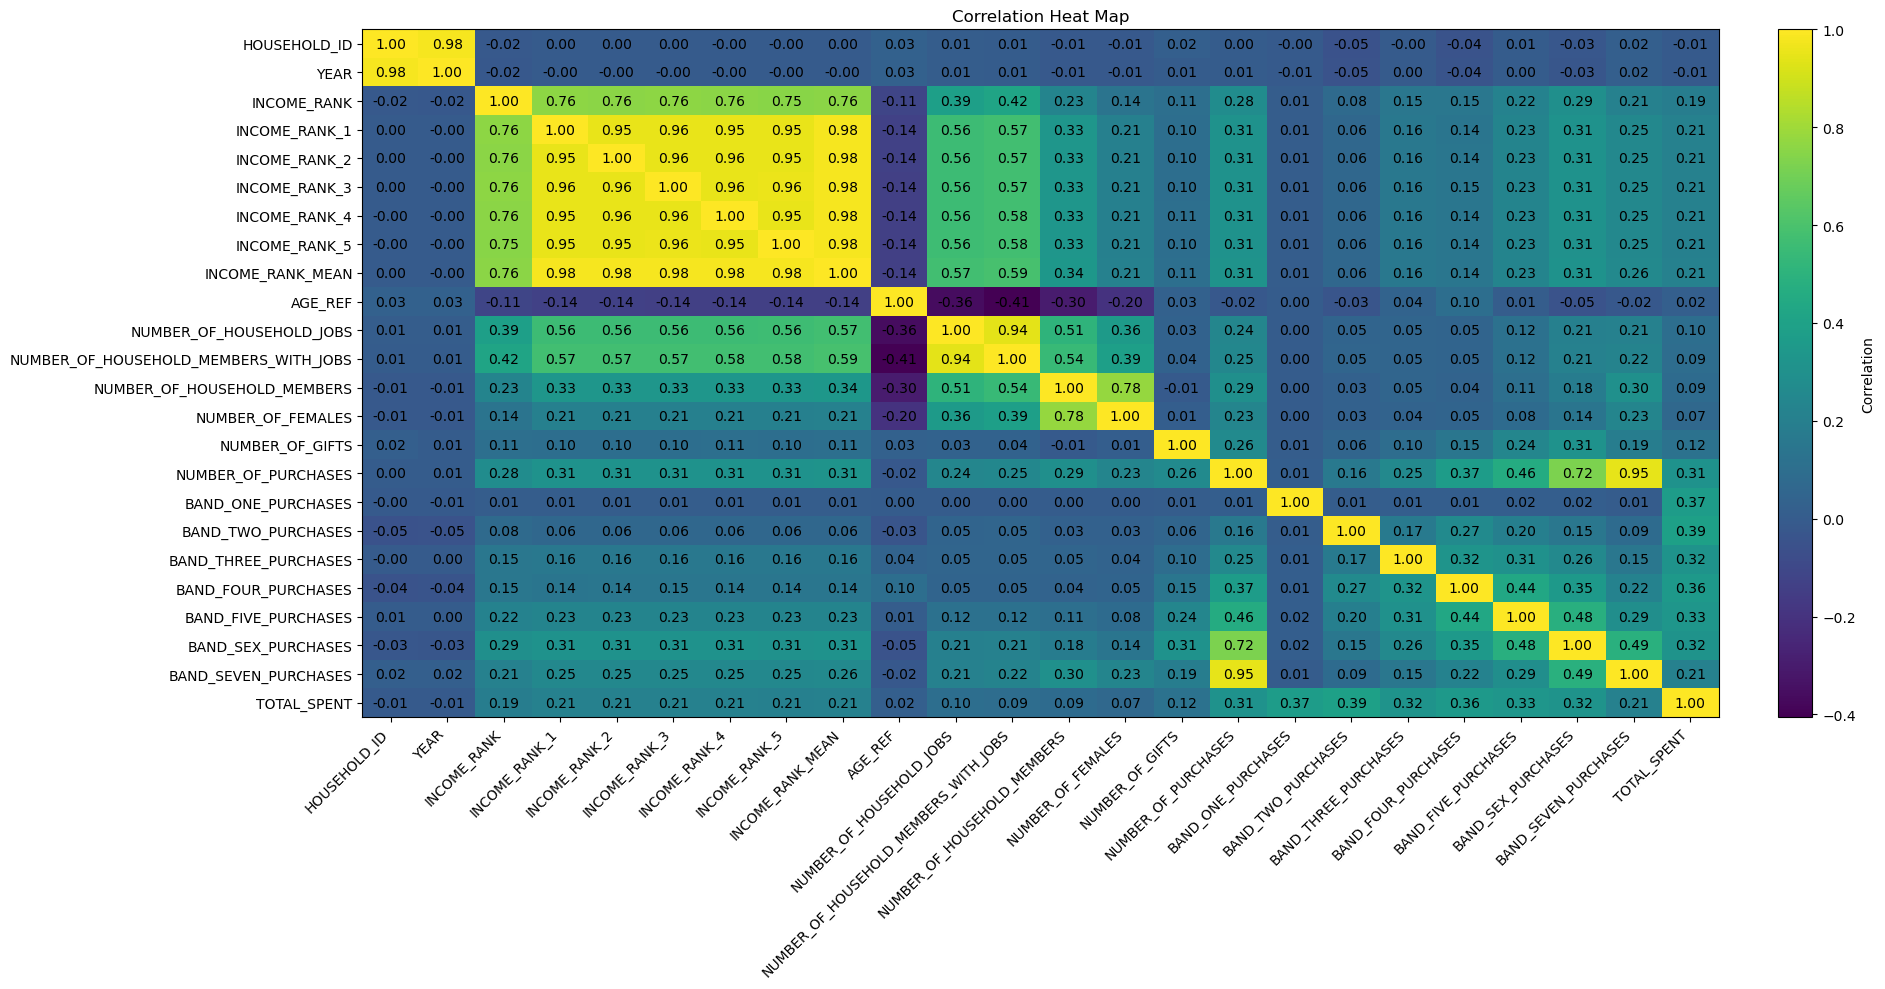

In [34]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(19, 10))
im = ax.imshow(corr.values, aspect='auto')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.index)
ax.set_title('Correlation Heat Map')

[ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center') for i in range(corr.shape[0]) for j in range(corr.shape[1])]

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()

In [35]:
df = df.drop(columns=['INCOME_RANK_1', 'INCOME_RANK_2','INCOME_RANK_3','INCOME_RANK_4','INCOME_RANK_5','NUMBER_OF_HOUSEHOLD_MEMBERS_WITH_JOBS'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52738 entries, 0 to 52737
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HOUSEHOLD_ID                 52738 non-null  int64  
 1   YEAR                         52738 non-null  int64  
 2   INCOME_RANK                  52738 non-null  float64
 3   INCOME_RANK_MEAN             52738 non-null  float64
 4   AGE_REF                      52738 non-null  int64  
 5   NUMBER_OF_HOUSEHOLD_JOBS     52738 non-null  int64  
 6   NUMBER_OF_HOUSEHOLD_MEMBERS  52738 non-null  int64  
 7   NUMBER_OF_FEMALES            52738 non-null  int64  
 8   NUMBER_OF_GIFTS              52738 non-null  int64  
 9   NUMBER_OF_PURCHASES          52738 non-null  int64  
 10  BAND_ONE_PURCHASES           52738 non-null  int64  
 11  BAND_TWO_PURCHASES           52738 non-null  int64  
 12  BAND_THREE_PURCHASES         52738 non-null  int64  
 13  BAND_FOUR_PURCHA

In [36]:
df.describe()

,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_MEAN,AGE_REF,NUMBER_OF_HOUSEHOLD_JOBS,NUMBER_OF_HOUSEHOLD_MEMBERS,NUMBER_OF_FEMALES,NUMBER_OF_GIFTS,NUMBER_OF_PURCHASES,BAND_ONE_PURCHASES,BAND_TWO_PURCHASES,BAND_THREE_PURCHASES,BAND_FOUR_PURCHASES,BAND_FIVE_PURCHASES,BAND_SEX_PURCHASES,BAND_SEVEN_PURCHASES,TOTAL_SPENT
count,5.273800e+04,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000,52738.000000
mean,3.712925e+06,2016.997042,0.525771,0.513869,51.579506,1.386609,2.443627,1.256855,0.800068,37.649342,0.001763,0.170920,0.214741,1.114604,1.116254,8.591092,26.439967,815.942079
std,3.599454e+05,1.401442,0.281409,0.288973,17.423915,1.088534,1.425903,0.912322,2.733305,26.818083,0.047470,0.465128,0.573628,1.652589,1.652456,7.736545,20.691937,1616.478990
min,3.111041e+06,2015.000000,0.000092,0.000092,15.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.397451e+06,2016.000000,0.289438,0.264938,37.000000,1.000000,1.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,11.000000,173.580000
50%,3.712852e+06,2017.000000,0.532948,0.521012,52.000000,1.000000,2.000000,1.000000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,23.000000,412.960000
75%,4.021952e+06,2018.000000,0.768586,0.766165,65.000000,2.000000,3.000000,2.000000,0.000000,52.000000,0.000000,0.000000,0.000000,2.000000,2.000000,12.000000,38.000000,931.422503
max,4.362672e+06,2019.000000,1.000000,1.000000,88.000000,10.000000,13.000000,10.000000,74.000000,357.000000,3.000000,10.000000,10.000000,24.000000,31.000000,148.000000,210.000000,83902.710000


Although we could solve this problem using regression, the client requested that we cluster the spenders into three categories: **low-income spenders**, **middle-income spenders**, and **high-income spenders**. Therefore, we cluster our spenders into these three buckets and assign the spenders to these three categories.

TOTAL_SPENT <= 100 represents Low-income spender = 1


TOTAL_SPENT > 100 AND TOTAL_SPENT <= 1000 represents Middle-income spender = 2


TOTAL_SPENT > 1000 represents High-income spender = 3

We apply **manual label encoding** when categorising the different classes: 1,2,3 represent low-income spenders, medium-income spenders, and high-income spenders respectively.

In [37]:
def income_spender_class(x):
    if x <= 100:
        return 1 # Low-income spenders
    if x > 100 and x <= 1000:
        return 2 # Middle-income spenders
    else:
        return 3 # High-income spenders



In [38]:
df['INCOME_SPENDER_CLASS'] = df['TOTAL_SPENT'].apply(income_spender_class)

Remove "pseudo" target variable

In [39]:
df = df.drop(columns=['TOTAL_SPENT'], errors='ignore')

Remaining Features

In [40]:
df.iloc[:,:-1].columns.tolist()

['HOUSEHOLD_ID',
 'YEAR',
 'INCOME_RANK',
 'INCOME_RANK_MEAN',
 'AGE_REF',
 'NUMBER_OF_HOUSEHOLD_JOBS',
 'NUMBER_OF_HOUSEHOLD_MEMBERS',
 'NUMBER_OF_FEMALES',
 'NUMBER_OF_GIFTS',
 'NUMBER_OF_PURCHASES',
 'BAND_ONE_PURCHASES',
 'BAND_TWO_PURCHASES',
 'BAND_THREE_PURCHASES',
 'BAND_FOUR_PURCHASES',
 'BAND_FIVE_PURCHASES',
 'BAND_SEX_PURCHASES',
 'BAND_SEVEN_PURCHASES']

Based on the scatter plots, we can see that High_income spenders (class label 3) tend to purchase more items (Feature: NUMBER_OF_PURCHASES) and gifts (Feature: NUMBER_OF_GIFTS).

We can see the same trend accross the different spending bands "Features: BAND_ONE_PURCHASES - BAND_SEVEN_PURCHASES"

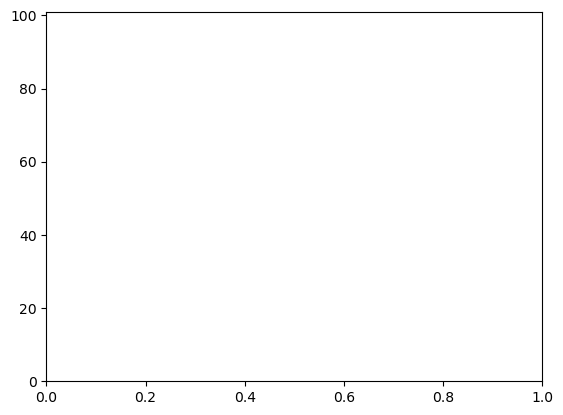

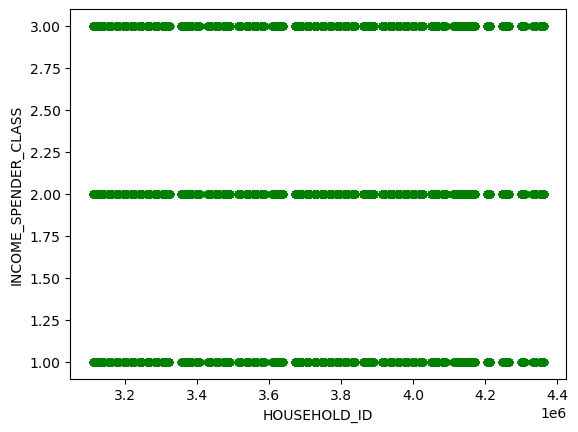

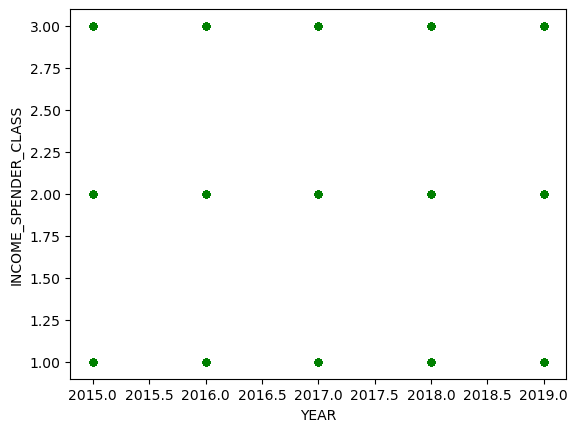

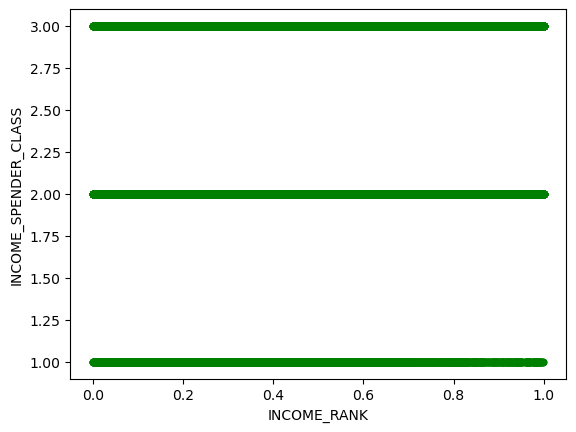

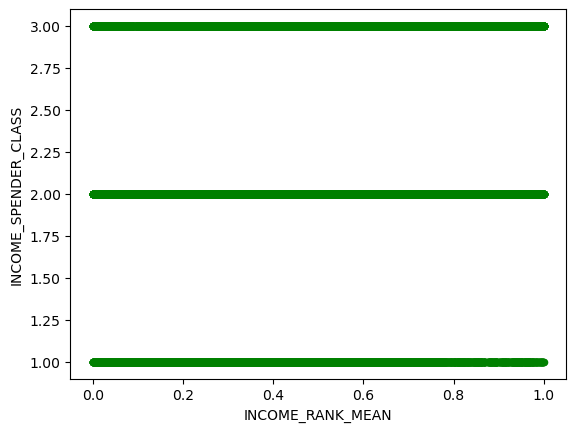

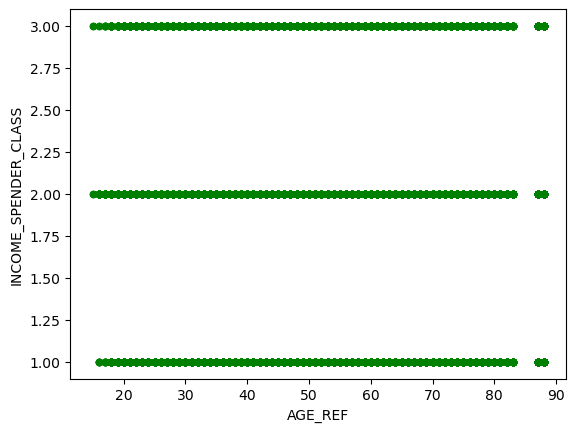

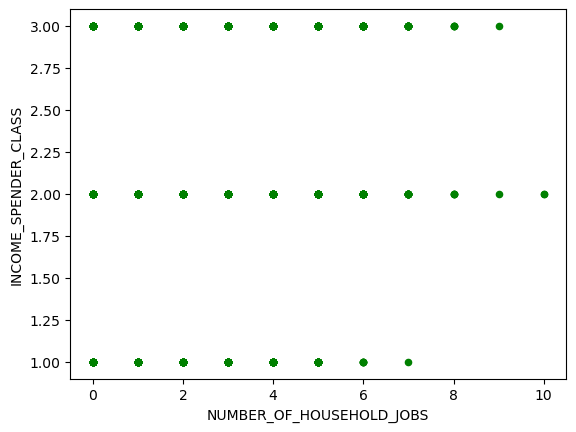

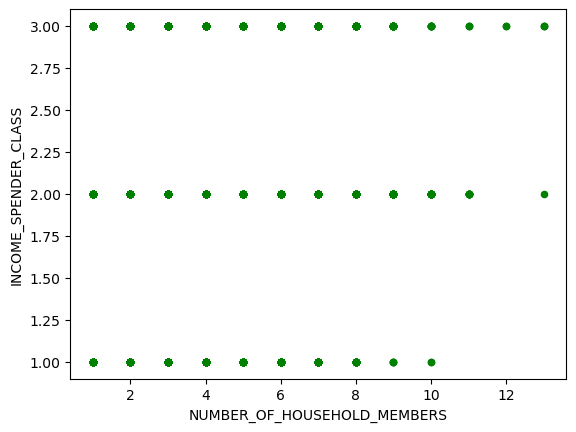

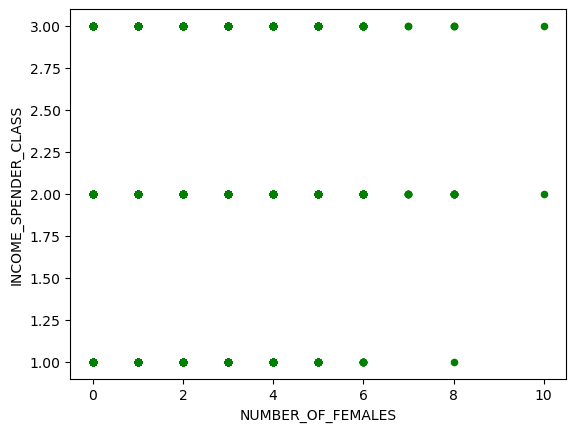

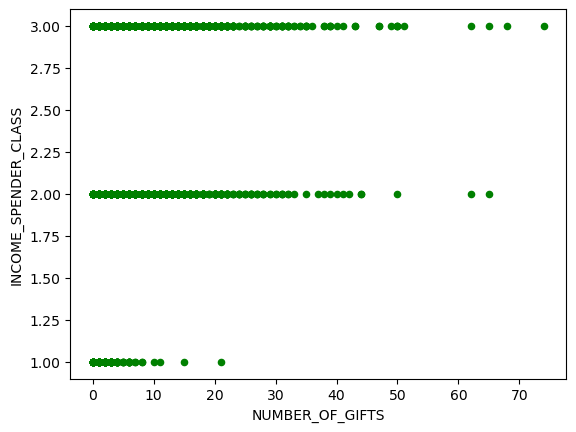

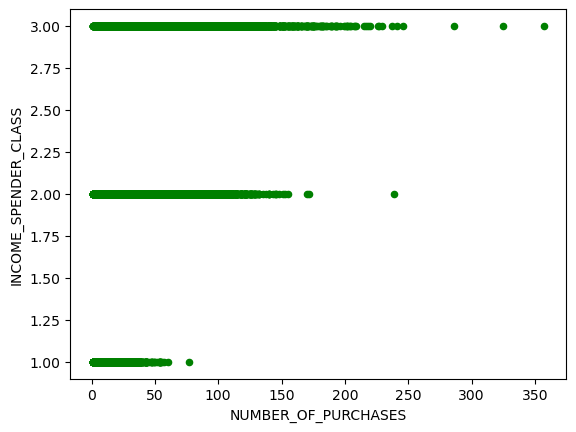

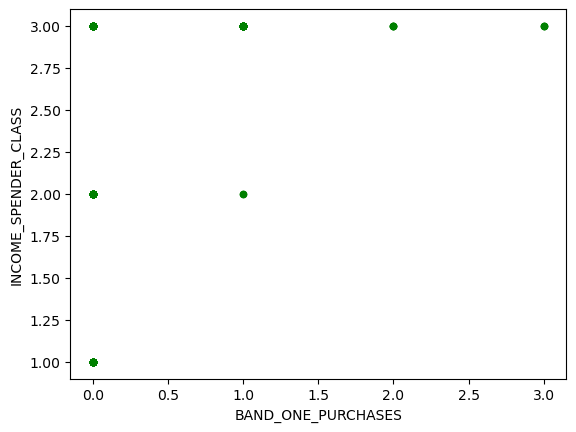

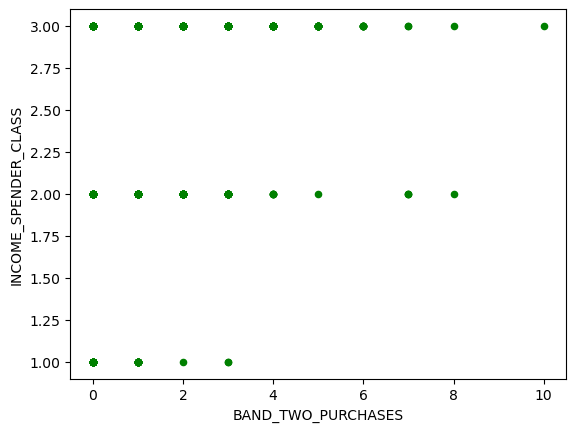

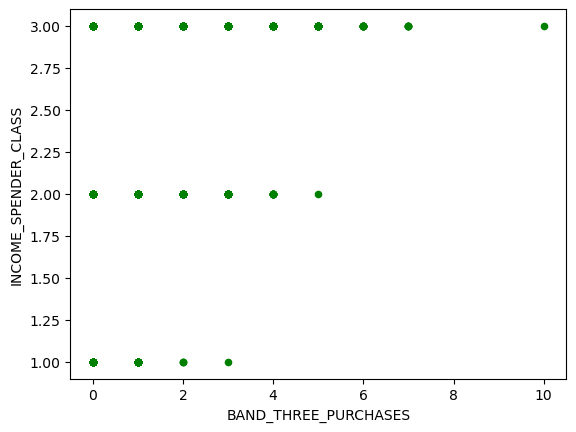

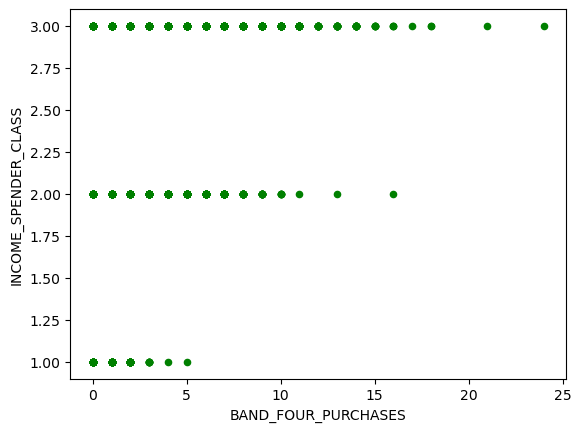

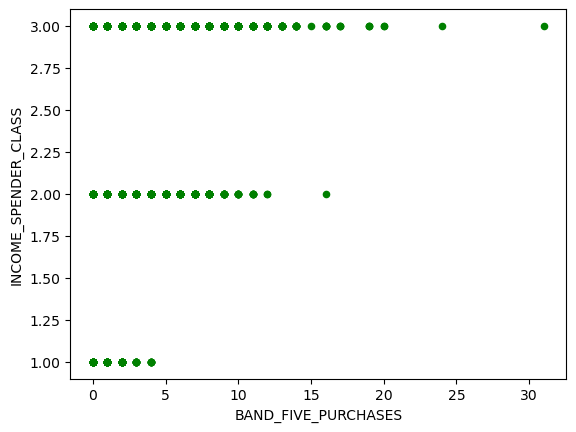

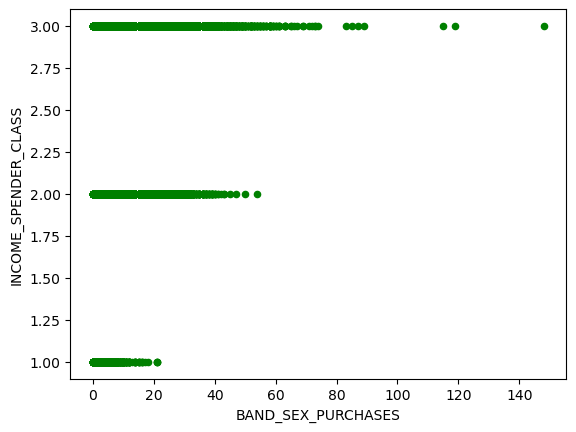

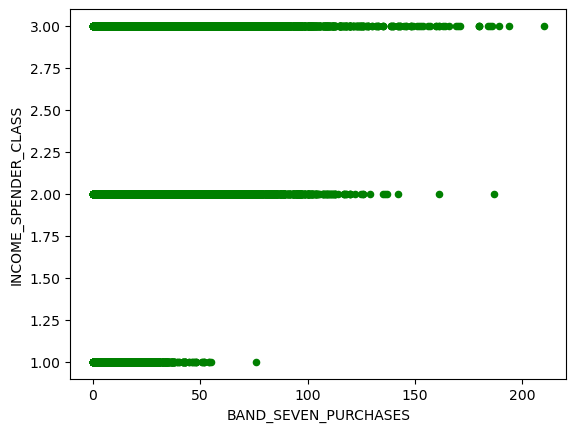

In [41]:
features = df.iloc[:,:-1].columns.tolist()

plt.ylim(0, 101)
for f in features:
    df.plot.scatter(x= f,
                  y='INCOME_SPENDER_CLASS',
                  c='green')

We now apply PCA to our dataset.
The Year feature is not predictive of the spender category but will be used later for the time based application of the model. It simply represents the year in which the survey was conducted.
Household_ID is a unique identifier and is also not predictive.
We use the 2019 data as the test set, and the data from 2015, 2016, 2017, and 2018 as the training set.

# Feature Reduction Method
### PCA

The function below allows us to apply PCA dynamically so that we can consistently select the best features. By setting and adjusting an explained variance threshold, we can determine which features will be retained.

In [42]:
def Dynamic_PCA(X_train,Y_train,X_test,Y_test,Explained_Variance_Cap,Already_Scaled_Indicator):

    if Already_Scaled_Indicator == 0:
      #We apply the standard scaler of the training dataset
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
    else:# Some ML models such as support vector machines/ Logistic regression will already require scaling to optimise performance. In these cases, we do not need to scale the already scaled dataset
      X_train_scaled = X_train
    #Number of features
    N_of_components = len(X_train.columns.tolist())

    #Initialise PCA model
    pca = PCA(n_components= N_of_components)
    X_train_pca = pca.fit_transform(X_train_scaled)

    #feature list
    df_columns = X_train.columns.tolist()
    dict_pca_features = {}

    #for c,p in zip (df_columns,pca.explained_variance_.tolist()):
        #dict_pca_features.update({c:[p]})
    #Explained variance per feature in data frame
    #print(pd.DataFrame(dict_pca_features, index = ['Explained Variannce']).head())

    #This section of code, will extract features according to the percentage of explain variance.
    #If the cap is at 90% then we keep including features until 90% of the explained variance is selected.
    var_list = pca.explained_variance_ratio_.tolist()
    total_variance = 0
    selected_features = []
    for v,c in zip(var_list,df_columns):
      if total_variance < Explained_Variance_Cap:
        total_variance = total_variance + v
        selected_features.append(c)
    print(f"Total variance: {total_variance}")
    #Print features selected
    print(f"Features selected: {selected_features}")

    X_Updated_train = X_train.loc[:,selected_features]
    X_Updated_test = X_test.loc[:,selected_features]
    #Return updated X train and X test sets based on selected features

    return X_Updated_train,Y_train,X_Updated_test,Y_test

# Model Build Functions

Functions would be used for model build to reduce the amount of hard coding bwhen implementing different models.

The function below implements dynamic grid search for hyperparameter tuning.Due to the imbalanced dataset, the recall_weighted metric was utilized to determine best hyperparameter combination.

In [43]:
def Hyperparameter_tuning(param_grid,X_train,Y_train,model):
  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='roc_auc_ovr_weighted',
              )

  grid_search.fit(X_train, Y_train)

  best_model_after_hyperparameter_tuning = grid_search.best_estimator_
  print("Selected Hyperparameters:", grid_search.best_params_)
  return best_model_after_hyperparameter_tuning

The function below, dynamically implements train and test evaluation metrics.

In [44]:
def Model_Evaluation_table(X_train,Y_train,X_test,Y_test,model,Explained_Variance_Cap):
    #Fit model on training and testing dataset
    model.fit(X_train, Y_train)
    #Predict train and test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_probability = model.predict_proba(X_train)
    y_test_probability = model.predict_proba(X_test)

    cm = confusion_matrix(Y_test, y_test_pred)
    print ('Testing Dataset Confusion Matrix:\n',cm, '\n')

    #Performance measures
    AUC_train = round(roc_auc_score(Y_train, y_train_probability, multi_class='ovr', average='weighted'),3)
    AUC_test = round(roc_auc_score(Y_test, y_test_probability, multi_class='ovr', average='weighted'),3)
    Precision_train = round(precision_score(Y_train, y_train_pred, average='weighted'),3)
    Precision_test = round(precision_score(Y_test,  y_test_pred, average='weighted'),3)
    Recall_train = round(recall_score(Y_train, y_train_pred, average='weighted'),3)
    Recall_test = round(recall_score(Y_test, y_test_pred, average='weighted'),3)


    #Model Performance
    Model_Evaluation_table = pd.DataFrame({
    'Model': [f"{model}",f"{model}"],
    'Explained Variance Threshold': [f"{Explained_Variance_Cap}",f"{Explained_Variance_Cap}"],
    'Features Used':[X_train.columns.tolist(),X_test.columns.tolist()],
    'Dataset': ['Training', 'Testing'],
    'AUC': [AUC_train, AUC_test],
    'Precision': [Precision_train,  Precision_test],
    'Recall': [Recall_train, Recall_test],
      })
    return Model_Evaluation_table

The function PCA_Model_Performance combines several steps to generate the final model results.
It first applies PCA (Dynamic_PCA function) to identify the best features. After that, it performs hyperparameter tuning (Hyperparameter_tuning) to obtain the optimal model based on the selected features, and finally, it generates the results using the Model_Evaluation_Table function.

In [45]:
def PCA_Model_Performance(X_train_initial,Y_train_initial,X_test_initial,Y_test_initial,model,param_grid,Explained_Variance_Cap,Already_Scaled_Indicator):
  X_train, Y_train, X_test, Y_test = Dynamic_PCA(X_train_initial,Y_train_initial,X_test_initial,Y_test_initial,Explained_Variance_Cap,Already_Scaled_Indicator)

  if param_grid != None:
    best_model_after_hyperparameter_tuning = Hyperparameter_tuning(param_grid,X_train,Y_train,model)
    print("Hyperparameter Tuning Complete")
    df_Model_Evaluation_table = Model_Evaluation_table(X_train,Y_train,X_test,Y_test,best_model_after_hyperparameter_tuning,Explained_Variance_Cap)

  else:
    df_Model_Evaluation_table = Model_Evaluation_table(X_train,Y_train,X_test,Y_test,model,Explained_Variance_Cap)



  return df_Model_Evaluation_table

# Pre-modeling Processing Steps

## Time Based Train/Test split

In the code below, we split the training and testing data based on time rather than using a random state. Years 2015–2018 will be used for training, and year 2019 will be used for testing.

Household_ID and Year will be removed from the dataset because they represent the unique identifier and the year of the survey. These features are not predictive.

In [46]:
condition = df['YEAR'] <= 2018
X_train = df[condition].drop(['INCOME_SPENDER_CLASS','HOUSEHOLD_ID','YEAR'], axis =1)
Y_train = df[condition]['INCOME_SPENDER_CLASS']

condition = df['YEAR'] == 2019
X_test =df[condition].drop(['INCOME_SPENDER_CLASS','HOUSEHOLD_ID','YEAR'], axis =1)
Y_test = df[condition]['INCOME_SPENDER_CLASS']

random_state_ = 50 # This ensures the model chosen is consisent. This allows for repeatable results.
Explained_Variance_Cap_ = 0.99 # 0.9 and 0.7

In [47]:
len(X_train.columns)

15

Dataset is slightly imbalanced.

In [48]:
condition = df['YEAR'] == 2019

df[condition][['INCOME_SPENDER_CLASS','HOUSEHOLD_ID']].groupby('INCOME_SPENDER_CLASS').agg(
    {    'HOUSEHOLD_ID': 'count',
    })

,HOUSEHOLD_ID
INCOME_SPENDER_CLASS,
1,1382
2,6601
3,2233


## Scaling

We implement Z-score scaling for features and apply it only to models that are negatively impacted when no scaling is implemented.

In [49]:
Scaled = StandardScaler()

X_Scaled_train = Scaled.fit_transform(X_train) # We apply fit transform only on train dataset. We only use the mean and standard deviation of the training dataset
df_Scaled_X_train = pd.DataFrame(X_Scaled_train, columns=X_train.columns)

X_Scaled_test = Scaled.transform(X_test) # We only apply transform on test dataset. We only use the mean and standard deviation of the training dataset
df_Scaled_X_test = pd.DataFrame(X_Scaled_test, columns=X_test.columns)

# Model Build

We implement Logistic Regression, Decision Trees, Random Forest and Light Gradient boosting models on our dataset.

## Logistic Regression

In [50]:
pd.set_option('display.max_colwidth', None)
df_model_results = pd.DataFrame()
model = LogisticRegression()
param_grid = {
    "max_iter": [200, 500],
    "C":[0.01,1,10]
              }
Explained_Variance_Cap = Explained_Variance_Cap_
Already_Scaled_Indicator = 1

#We apply scaling to Logistic Regression
#The PCA_Model_Performance function generates a dataFrame with the evaluation results of the model. We continuously add these results to the df_model_results dataframe.
#This allows for easier comparison between models.
df_model_results = pd.concat([df_model_results,PCA_Model_Performance(df_Scaled_X_train,Y_train,df_Scaled_X_test,Y_test,model,param_grid,Explained_Variance_Cap,Already_Scaled_Indicator)])

Total variance: 1.0000000000000002
Features selected: ['INCOME_RANK', 'INCOME_RANK_MEAN', 'AGE_REF', 'NUMBER_OF_HOUSEHOLD_JOBS', 'NUMBER_OF_HOUSEHOLD_MEMBERS', 'NUMBER_OF_FEMALES', 'NUMBER_OF_GIFTS', 'NUMBER_OF_PURCHASES', 'BAND_ONE_PURCHASES', 'BAND_TWO_PURCHASES', 'BAND_THREE_PURCHASES', 'BAND_FOUR_PURCHASES', 'BAND_FIVE_PURCHASES', 'BAND_SEX_PURCHASES']
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Selected Hyperparameters: {'C': 1, 'max_iter': 200}
Hyperparameter Tuning Complete
Testing Dataset Confusion Matrix:
 [[1086  296    0]
 [ 337 5983  281]
 [   0  772 1461]] 



## Decision Tree

After implementing a grid search, the best decision tree was selected. The following were the best set of hyperparameters for Explained Variance threshold of 0.99:

`
    'max_depth': [10],
    'criterion':["entropy"],
    'min_samples_split':[10],
    'min_samples_leaf': [2],
    'max_features':["sqrt"]
`

Although the grid search was done, to reduce notebook running time, the entire grid search was not included in the code.

Original grid search is seen below:

 `
param_grid = {
    'max_depth': [3,5,7,10],
    'criterion':["gini", "entropy"],
    'min_samples_split': [3, 4,8, 10],
    'min_samples_leaf': [2,3, 4,6,10],
    'max_features':["sqrt", "log2"]
              }
 `

Hyperparameters were specifically chosen to avoid overfitting.

In [51]:
model = DecisionTreeClassifier(random_state = random_state_) #Random state within the model, makes sure that the model selected is constant. This will allow us to have the same results after re-running the notebook.
param_grid = {
    'max_depth': [10],
    'criterion':["entropy"],
    'min_samples_split':[10],
    'min_samples_leaf': [2],
    'max_features':["sqrt"]
              }
Explained_Variance_Cap = Explained_Variance_Cap_
Already_Scaled_Indicator = 0


df_model_results = pd.concat([df_model_results,PCA_Model_Performance(X_train,Y_train,X_test,Y_test,model,param_grid,Explained_Variance_Cap,Already_Scaled_Indicator)])

Total variance: 1.0000000000000002
Features selected: ['INCOME_RANK', 'INCOME_RANK_MEAN', 'AGE_REF', 'NUMBER_OF_HOUSEHOLD_JOBS', 'NUMBER_OF_HOUSEHOLD_MEMBERS', 'NUMBER_OF_FEMALES', 'NUMBER_OF_GIFTS', 'NUMBER_OF_PURCHASES', 'BAND_ONE_PURCHASES', 'BAND_TWO_PURCHASES', 'BAND_THREE_PURCHASES', 'BAND_FOUR_PURCHASES', 'BAND_FIVE_PURCHASES', 'BAND_SEX_PURCHASES']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Selected Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Hyperparameter Tuning Complete
Testing Dataset Confusion Matrix:
 [[ 950  432    0]
 [ 315 5871  415]
 [   9  819 1405]] 



## Random Forest

Due to the lengthy training time, hyperparameters were selected with the goal of reducing overfitting. Only one set was chosen because of the long time required to implement more complex grid search on the Random Forest algorithm.



In [52]:
model = RandomForestClassifier(random_state = random_state_)
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'criterion':["entropy"],
    'min_samples_split': [10],
    'min_samples_leaf': [3],
    'max_features':["sqrt"]
              }
#param_grid = None
Explained_Variance_Cap = Explained_Variance_Cap_
Already_Scaled_Indicator = 0

df_model_results = pd.concat([df_model_results,PCA_Model_Performance(X_train,Y_train,X_test,Y_test,model,param_grid,Explained_Variance_Cap,Already_Scaled_Indicator)])

Total variance: 1.0000000000000002
Features selected: ['INCOME_RANK', 'INCOME_RANK_MEAN', 'AGE_REF', 'NUMBER_OF_HOUSEHOLD_JOBS', 'NUMBER_OF_HOUSEHOLD_MEMBERS', 'NUMBER_OF_FEMALES', 'NUMBER_OF_GIFTS', 'NUMBER_OF_PURCHASES', 'BAND_ONE_PURCHASES', 'BAND_TWO_PURCHASES', 'BAND_THREE_PURCHASES', 'BAND_FOUR_PURCHASES', 'BAND_FIVE_PURCHASES', 'BAND_SEX_PURCHASES']
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Selected Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
Hyperparameter Tuning Complete
Testing Dataset Confusion Matrix:
 [[ 968  414    0]
 [ 213 6078  310]
 [   0  760 1473]] 



## Light Gradient Boosting

Light Gradient boosting was selected over XgBoost due to its faster training time.

In [53]:
model = LGBMClassifier(random_state = random_state_,force_col_wise=True)
param_grid = {
            "learning_rate": [0.01,0.05,0.1,1]
              }
Explained_Variance_Cap = Explained_Variance_Cap_
Already_Scaled_Indicator = 0

df_model_results = pd.concat([df_model_results,PCA_Model_Performance(X_train,Y_train,X_test,Y_test,model,param_grid,Explained_Variance_Cap,Already_Scaled_Indicator)])

Total variance: 1.0000000000000002
Features selected: ['INCOME_RANK', 'INCOME_RANK_MEAN', 'AGE_REF', 'NUMBER_OF_HOUSEHOLD_JOBS', 'NUMBER_OF_HOUSEHOLD_MEMBERS', 'NUMBER_OF_FEMALES', 'NUMBER_OF_GIFTS', 'NUMBER_OF_PURCHASES', 'BAND_ONE_PURCHASES', 'BAND_TWO_PURCHASES', 'BAND_THREE_PURCHASES', 'BAND_FOUR_PURCHASES', 'BAND_FIVE_PURCHASES', 'BAND_SEX_PURCHASES']
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\me\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\me\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\me\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\me\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 42522, number of used features: 14
[LightGBM] [Info] Start training from score -1.957429
[LightGBM] [Info] Start training from score -0.471030
[LightGBM] [Info] Start training from score -1.450642
Selected Hyperparameters: {'learning_rate': 0.05}
Hyperparameter Tuning Complete
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 42522, number of used features: 14
[LightGBM] [Info] Start training from score -1.957429
[LightGBM] [Info] Start training from score -0.471030
[LightGBM] [Info] Start training from score -1.450642
Testing Dataset Confusion Matrix:
 [[1041  341    0]
 [ 287 5943  371]
 [   0  647 1586]] 



In [54]:
df_model_results

,Model,Explained Variance Threshold,Features Used,Dataset,AUC,Precision,Recall
0,"LogisticRegression(C=1, max_iter=200)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Training,0.925,0.833,0.834
1,"LogisticRegression(C=1, max_iter=200)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Testing,0.918,0.835,0.835
0,"DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',\n min_samples_leaf=2, min_samples_split=10,\n random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Training,0.924,0.831,0.832
1,"DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',\n min_samples_leaf=2, min_samples_split=10,\n random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Testing,0.886,0.802,0.805
0,"RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,\n min_samples_split=10, random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Training,0.946,0.857,0.856
1,"RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,\n min_samples_split=10, random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Testing,0.918,0.833,0.834
0,"LGBMClassifier(force_col_wise=True, learning_rate=0.05, random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Training,0.942,0.853,0.854
1,"LGBMClassifier(force_col_wise=True, learning_rate=0.05, random_state=50)",0.99,"[INCOME_RANK, INCOME_RANK_MEAN, AGE_REF, NUMBER_OF_HOUSEHOLD_JOBS, NUMBER_OF_HOUSEHOLD_MEMBERS, NUMBER_OF_FEMALES, NUMBER_OF_GIFTS, NUMBER_OF_PURCHASES, BAND_ONE_PURCHASES, BAND_TWO_PURCHASES, BAND_THREE_PURCHASES, BAND_FOUR_PURCHASES, BAND_FIVE_PURCHASES, BAND_SEX_PURCHASES]",Testing,0.920,0.837,0.839


In [55]:
df_model_results.to_excel(f'model_results {Explained_Variance_Cap_}.xlsx')